# ACME: Iterative Solvers
## Jincheng(Eric) Huang

1. Write a function that accepts a matrix $A$, a vector $b$, a convergence tolerance tol, and a maximum number of iterations `maxiters`. Implement the Jacobi method using (16.2), returning the approximate solution to the equation $Ax = b$.

    Run the iteration until $\left\|\mathbf{x}^{(k-1)}-\mathbf{x}^{(k)}\right\|_{\infty}<tol$, and only iterate at most maxiters times. Avoid using `la.inv()` to calculate $D^{-1}$, but use `la.norm()` to calculate the vector $\infty$-norm $\|\mathbf{x}\|_{\infty}=\sup \left|x_{i}\right|$.
    
    Your function should be robust enough to accept systems of any size. To test your function, generate a random $\mathbb{b}$ with `np.random.random()` and use the following function to generate an $n\times n$ matrix $A$ for which the Jacobi method is guaranteed to converge. Run the iteration, then check that $Ax(k)$ and $b$ are close using `np.allclose()`.

In [1]:
def diag_dom(n, num_entries=None):
    """Generate a strictly diagonally dominant (n, n) matrix.
    Parameters:
    n (int): The dimension of the system.
    num_entries (int): The number of nonzero values.
    Defaults to n^(3/2)-n.
    Returns:
    A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
    """
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

Also test your function on random $n \times n$ matrices. If the iteration is non-convergent, the successive approximations will have increasingly large entries.

In [2]:
def jacobi_solver(A,b,tol,maxiters,plot=False):
    """Use the Jacobi method to solve for a system of linear equations Ax = b
    Parameters:
    A: An n by n matrix of coefficients
    b: An n by 1 vector
    Returns:
    x: solution to the system
    robust: whether the convergence criterion is met
    """
    n = A.shape[0]
    x = np.ones((n,1))
    b = b.reshape((n,1))
    D = np.diag(A)
    D_inv = np.diag(1/D)
    diff = np.inf
    abs_error = []
    niter = 1
    
    while diff > tol and niter <= maxiters:
        x_new = x + D_inv.dot(b-A.dot(x))
        diff = la.norm(x_new-x,np.inf)
        x = x_new.copy()
        abs_error.append(diff)
        
        niter = niter + 1
        
    robust = np.allclose(diff, 0)
    
    if plot:
        plt.semilogy(np.arange(1,niter,1),abs_error)
        plt.title('Convergence of Jacobi Method')
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.show()
    return x,robust

2. Modify your Jacobi method function in the following ways.

    1) Add a keyword argument called `plot`, defaulting to `False`.
    
    2) Keep track of the absolute error $\left\|A \mathbf{x}^{(k)}-\mathbf{b}\right\|_{\infty}$ of the approximation at each iteration.
    
    3) If `plot` is True, produce a lin-log plot (use `plt.semilogy())` of the error against iteration count. Remember to still return the approximate solution $x$.

In [3]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt

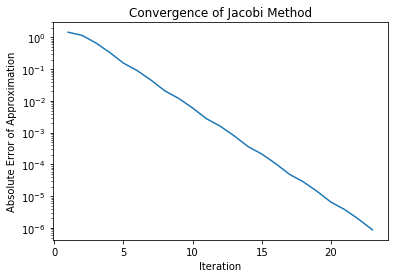

In [4]:
A = diag_dom(5)
x,robust = jacobi_solver(A,np.random.random(5),1e-6,100,plot=True)

In [5]:
# Print the result
print(x)
print('The Jacobi method has converged: %r' %robust)

[[ 0.28671186]
 [-0.00166867]
 [ 0.21181361]
 [-0.01877712]
 [ 0.30467043]]
The Jacobi method has converged: False


3. Write a function that accepts a matrix $A$, a vector $b$, a convergence tolerance `tol`, a maximum number of iterations maxiters, and a keyword argument plot that defaults to `False`. Implement the Gauss-Seidel method using (16.4), returning the approximate solution to the equation $Ax = b$.

In [6]:
def gauss_seidel_solver(A, b, tol = 1e-6, maxiter = 500, plot = False):
    
    b = b.reshape(len(b), 1)
    x = np.zeros_like(b)
    xp = np.zeros_like(b)
    abserror = []
    
    for i in range(maxiter):
        for j in range(len(A)):
            xp[j, :] = x[j, :] + 1/A[j, j] * (b[j, :] - A[j, :] @ x)
        
        diff = la.norm(xp - x, np.inf)
        x = xp.copy()
        abserror.append(la.norm(A@x - b, np.inf))
        
        if diff < tol:
            break
            
    if plot:
        plt.semilogy(np.arange(1, i+2, 1), abserror)
        plt.title('Convergence of Guass_Seidel Method')
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.show()
        
    robust = np.allclose(A @ x, b)
        
    return x,robust

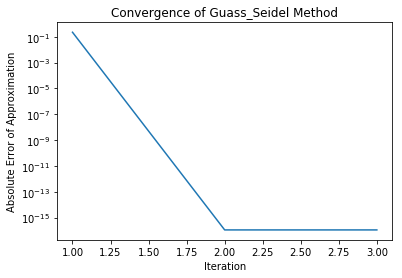

In [7]:
x,robust = gauss_seidel_solver(diag_dom(5), np.random.random(5), plot = True)

In [8]:
# Print results
print(x)
print('The Gauss-Seidel method has converged: %r' %robust)

[[0.05645351]
 [0.15600087]
 [0.72305985]
 [0.36134397]
 [0.06858943]]
The Gauss-Seidel method has converged: True


4. Write a new function that accepts a sparse matrix $A$, a vector $b$, a convergence tolerance $tol$, and a maximum number of iterations `maxiters` (plotting the convergence is not required for this problem). Implement the Gauss-Seidel method using (16.4), returning the approximate solution to the equation $Ax = b$. Use the usual stopping criterion.

    The Gauss-Seidel method requires extracting the rows $A_i$ from the matrix $A$ and computing $A^T_ix$. There are many ways to do this that cause some fairly serious runtime issues, so we provide the code for this specific portion of the algorithm.
    
    To test your function, cast the result of diag_dom() as a sparse matrix.

In [9]:
from scipy import sparse

In [14]:
def GS_sparse(A, b, tol = 1e-6, maxiter = 1000):
    
    b = b.reshape(len(b), 1)
    x = np.zeros_like(b)
    xp = np.zeros_like(b)
    abserror = []
    
    for i in range(maxiter):
        for j in range(len(b)):
            # deal with sparse matrix
            rowstart = A.indptr[j]
            rowend = A.indptr[j+1]
            Aix = A.data[rowstart: rowend] @ x[A.indices[rowstart: rowend]]
            xp[j, :] = x[j, :] + 1/A[j, j] * (b[j, :] - Aix)
        
        diff = la.norm(xp - x, np.inf)
        x = xp.copy()
        abserror.append(la.norm(A@x - b, np.inf))
        
        if diff < tol:
            break
            
        
    robust = np.allclose(A @ x, b)
        
    return x,robust

In [15]:
C = sp.sparse.csr_matrix(diag_dom(5000))

In [16]:
x,robust = GS_sparse(C, np.random.random(5000))

In [17]:
# Print results
print(x)
print('The Gauss-Seidel method has converged: %r' %robust)

[[0.00776347]
 [0.00446686]
 [0.00116636]
 ...
 [0.0043238 ]
 [0.00739404]
 [0.00456112]]
The Gauss-Seidel method has converged: False


5. Write a function that accepts a sparse matrix $A$, a vector $b$, a relaxation factor $\omega$, a convergence tolerance $tol$, and a maximum number of iterations maxiters. Implement SOR using (16.5), compute the approximate solution to the equation $Ax = b$. Use the usual stopping criterion. Return the approximate solution x as well as the number of iterations computed. (Hint: this requires changing only one line of code from the sparse Gauss-Seidel function.)

In [18]:
def SOR_sparse(A, b, tol = 1e-6, ω = 1, maxiter = 1000, plot = False):
    
    b = b.reshape(len(b), 1)
    x = np.zeros_like(b)
    xp = np.zeros_like(b)
    abserror = []
    
    for i in range(maxiter):
        for j in range(len(b)):
            # deal with sparse matrix
            rowstart = A.indptr[j]
            rowend = A.indptr[j+1]
            Ai = A.data[rowstart: rowend].reshape(1, len(A.indices[rowstart: rowend]))
            Aix = Ai @ x[A.indices[rowstart: rowend]]
            xp[j, :] = x[j, :] + (ω/A[j, j]) * (b[j, :] - Aix)
        
        diff = la.norm(xp - x, np.inf)
        x = xp.copy()
        abserror.append(la.norm(A@x - b, np.inf))
        
        if diff < tol:
            break
            
    if plot:
        plt.semilogy(np.arange(1, i+2, 1), abserror)
        plt.title('Convergence of Guass_Seidel Method')
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.show()
        
    iterations = i+1
    
    return x, iterations

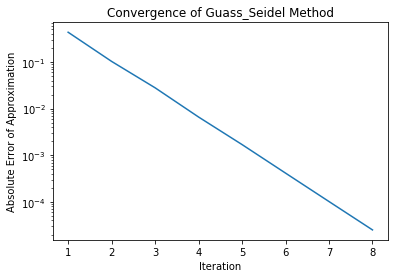

In [19]:
x,iterations = SOR_sparse(C, np.random.random(5000), plot = True)

6. Write a function that accepts an integer $n$, a relaxation factor $\omega$, a convergence tolerance $tol$ that defaults to $10^{-8}$, a maximum number of iterations maxiters that defaults to 100, and a bool plot that defaults to `False`. Generate and solve the corresponding system $Au = b$ using Problem 5. Also return the number of iterations computed. (Hint: see Problem 5 of the Linear Systems lab for the construction of $A$. Also, `np.tile()` may be useful for constructing $b$.)

    If `plot=True`, visualize the solution $u$ with a heatmap using `plt.pcolormesh()` (the colormap "coolwarm" is a good choice in this case). This shows the distribution of heat over the hot plate after it has reached its steady state. Note that the $u$ must be reshaped as an $n \times n$ array to properly visualize the result.

In [20]:
def heat_finite_difference(n, ω, tol = 1e-2, maxiter = 1000, plot = False):
    
    # B
    B = sp.sparse.diags([1, -4, 1], [-1, 0, 1], shape = (n, n))
    
    # A
    I = sp.sparse.diags([1], shape = (n, n)) # identity

    Amat = []
    for i in range(n):
        Arow = []
        for j in range(n):
            if j < i - 1:
                Arow.append(None)
            elif j == i - 1:
                Arow.append(I)
            elif j == i:
                Arow.append(B)
            elif j == i + 1:
                Arow.append(I)
            else:
                Arow.append(None)
        Amat.append(Arow)
        
    A = sp.sparse.bmat(Amat, format = 'csr')
    lilb = np.zeros(n)
    lilb[0] = -100
    lilb[-1] = -100
    b = np.tile(lilb, n)

    u, iterations = SOR_sparse(A, b, tol, ω, maxiter, plot = False)
    
    if plot:
        xx = np.linspace(0, n ,n+1)
        yy = np.linspace(0, n, n+1)
        X, Y = np.meshgrid(xx, yy)
        u_2d = u.reshape((n, n))
        plt.figure(figsize = (9,7))
        plt.pcolormesh(X, Y, u_2d, cmap = 'coolwarm')
        plt.title('heat')
        plt.colorbar()
        plt.show()
    
    return u, iterations

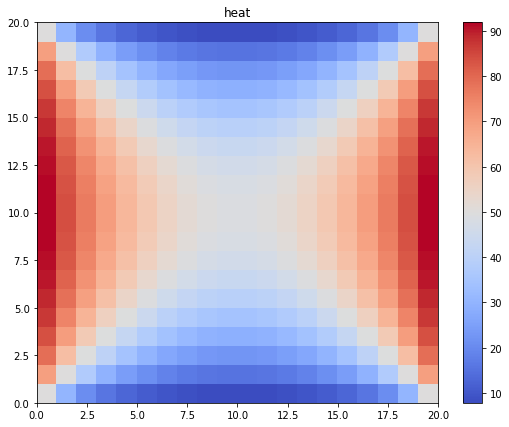

In [21]:
u, iterations = heat_finite_difference(20, 1, plot = True)

7. To demonstrate how convergence is affected by the value of the relaxation factor $\omega$ in SOR, run your function from Problem 6 with $\omega = 1, 1.05, 1.1, ... , 1.9, 1.95$ and $n = 20$. Plot the number of computed iterations as a function of $\omega$. Return the value of $\omega$ that results in the least number of iterations.

    Note that the matrix $A$ from Problem 6 is not strictly diagonally dominant. However, $A$ is positive definite, so the algorithm will converge. Unfortunately, convergence for these kinds of systems usually requires more iterations than for strictly diagonally dominant systems. Therefore, set $tol=1e-2$ and $maxiters=1000$. Recall that $\omega = 1$ corresponds to the Gauss-Seidel method. Choosing a more optimal relaxation factor saves a large number of iterations. This could translate to saving days or weeks of computation time while solving extremely large linear systems on a supercomputer.

In [26]:
def compare_relaxation(n):
    ωlist = np.arange(0.01, 1, 0.05)
    iterations = []
    
    for ω in ωlist:
        u, iters = heat_finite_difference(n, ω, plot = False)
        iterations.append(iters)
    
    fig = plt.figure(figsize=(7, 7))
    plt.plot(ωlist, iterations)
    plt.xlabel('$\omega$')
    plt.ylabel('Number of Iterations')
    plt.title('convergence rate vs relaxation factor')
    plt.show()
    
    iterations = np.array(iterations)
    return ωlist[np.argmin(iterations)]

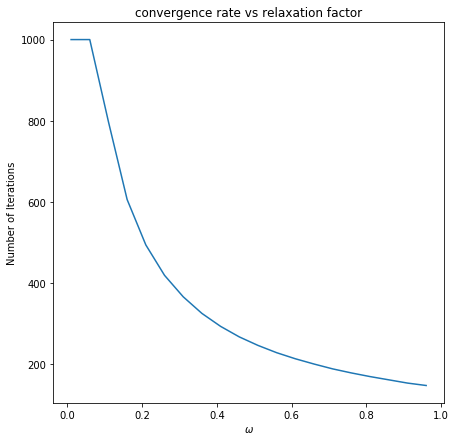

In [27]:
ωlist = compare_relaxation(10)